In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
mtx_ours_path = "C:/Users/Tobias Bodmer/Downloads/benchmark_ours/ours_timingMatrix1626235245.npy"
mtx_ref_path = "C:/Users/Tobias Bodmer/Downloads/benchmark_theirs/others_timingMatrix1626272945.npy"
taxa_values = [125, 1481, 218, 714, 141, 24, 885, 2000, 354, 1604, 2308, 350, 1288, 1512, 2554, 1908, 150, 143, 148, 404, 500, 628, 994]
tree_values = [2,10,100,300]
# arrays have the dimensions [numberofTrees_idx][File / number_taxa_id][metric]


In [2]:
ref = np.load(mtx_ref_path, allow_pickle=True)*1e-9
ours = np.load(mtx_ours_path, allow_pickle=True)*1e-9
num_taxa = np.array(taxa_values)
perm = np.argsort(num_taxa)
num_taxa = num_taxa[perm]
ref = ref[:,perm,:]
ours = ours[:,perm,:]

In [3]:
def deleteZeroRows(inArr):
    rowsToDelete = []
    for i in range(np.shape(inArr)[0]):
        if not np.any(inArr[i]):
            rowsToDelete.append(i)
    return np.delete(inArr, rowsToDelete, 0)
def getInvalidMask(inArr):
    bad_values = [0,-1e-9,-2e-9] # not evaluated | error | timeout
    negativeMask = np.isin(inArr,bad_values)
    return ~negativeMask
def getTimeoutMask(inArr):
    bad_values = [-2e-9]
    negativeMask = np.isin(inArr,bad_values)
    return ~negativeMask
def getErrMask(inArr):
    bad_values = [-1e-9]
    negativeMask = np.isin(inArr,bad_values)
    return ~negativeMask

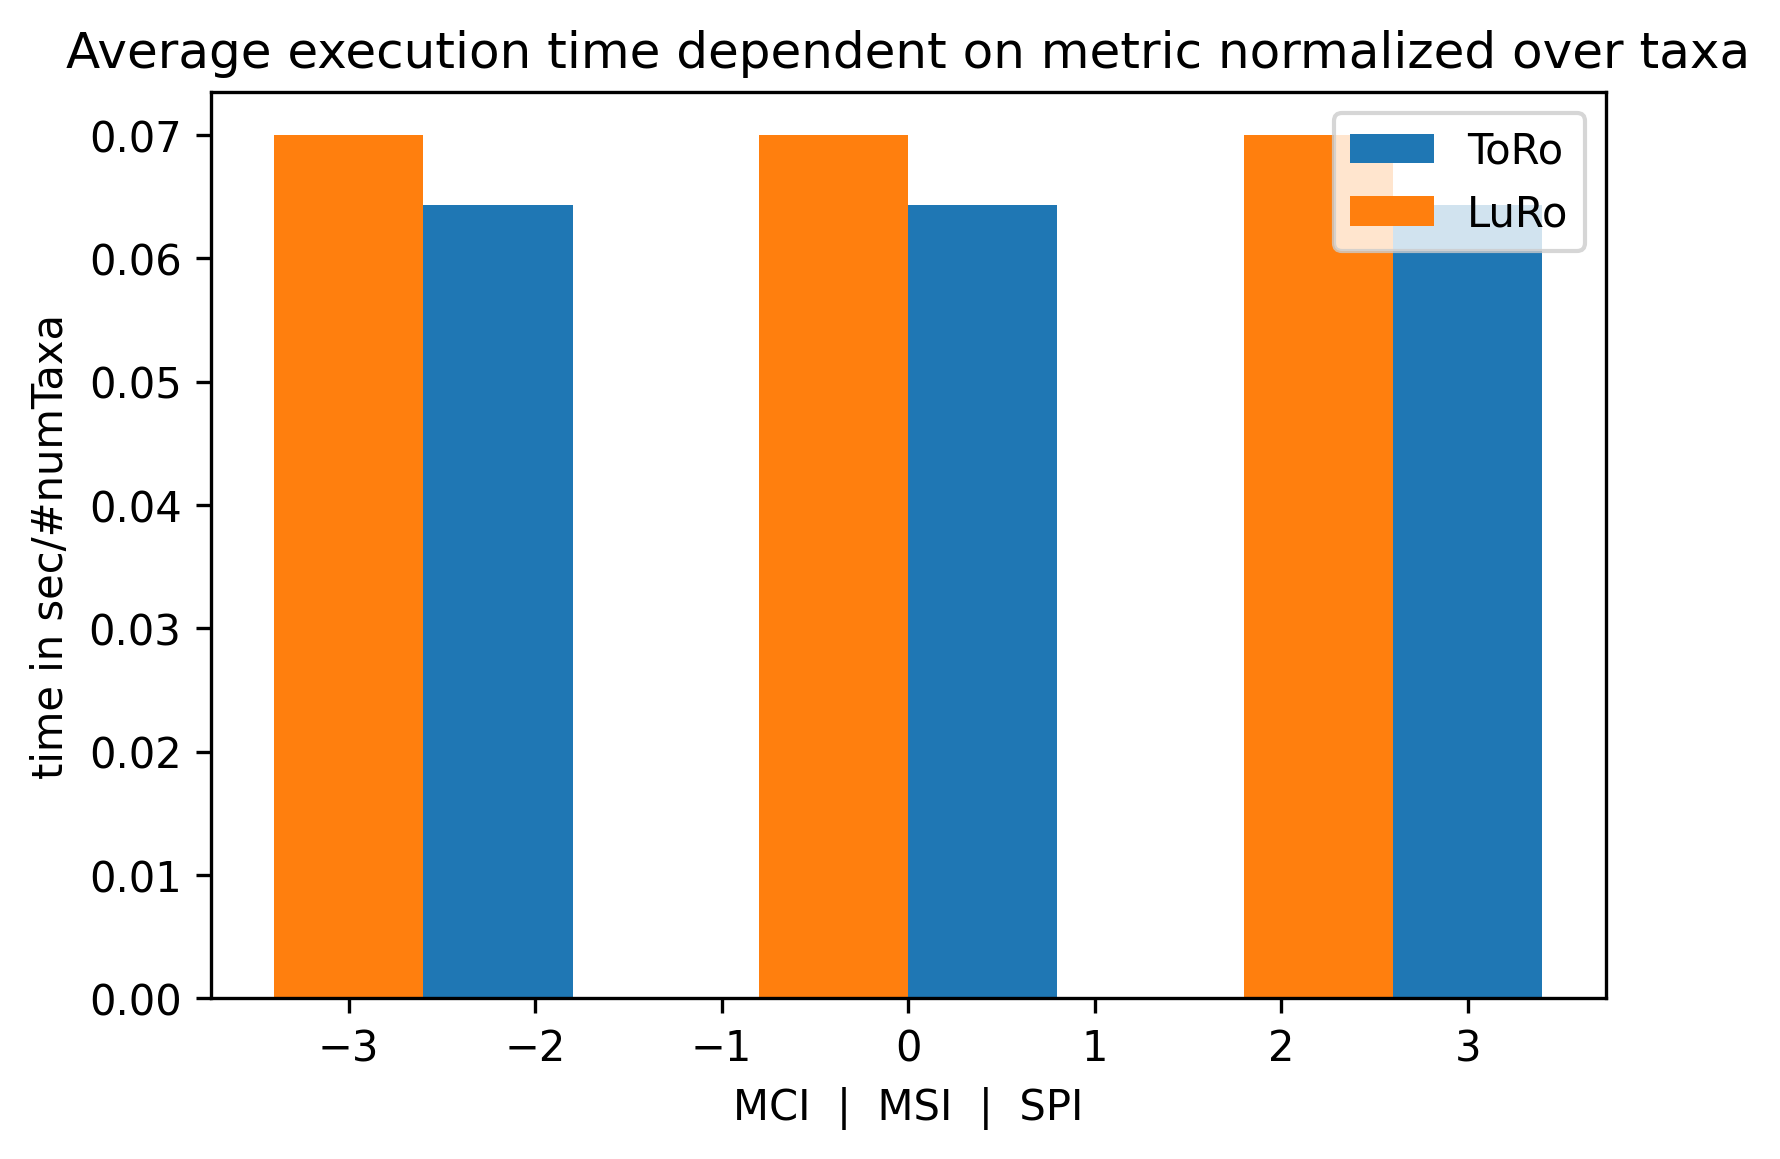

In [9]:
invMO = np.all(getInvalidMask(ours),axis=2)
invMR = np.all(getInvalidMask(ref),axis=2)
taxa_mat = np.dstack([num_taxa]*len(tree_values))[0].T
invTaxaO = 1/taxa_mat[invMO]
invTaxaR = 1/taxa_mat[invMR]
weightTaxaO = np.einsum('ta,ta->ta',ours[invMO], invTaxaO[...,np.newaxis])
weightTaxaR = np.einsum('ta,ta->ta',ref[invMR],invTaxaR[...,np.newaxis])
plt.bar([-2.2,.4,3], np.average(weightTaxaO,axis=0)[1], label="ToRo")
plt.bar([-3,-.4,2.2], np.average(weightTaxaR,axis=0)[1], label="LuRo")
plt.ylabel("time in sec/#numTaxa")
plt.xlabel("MCI  |  MSI  |  SPI")
plt.title("Average execution time dependent on metric normalized over taxa")
plt.legend()
plt.show()

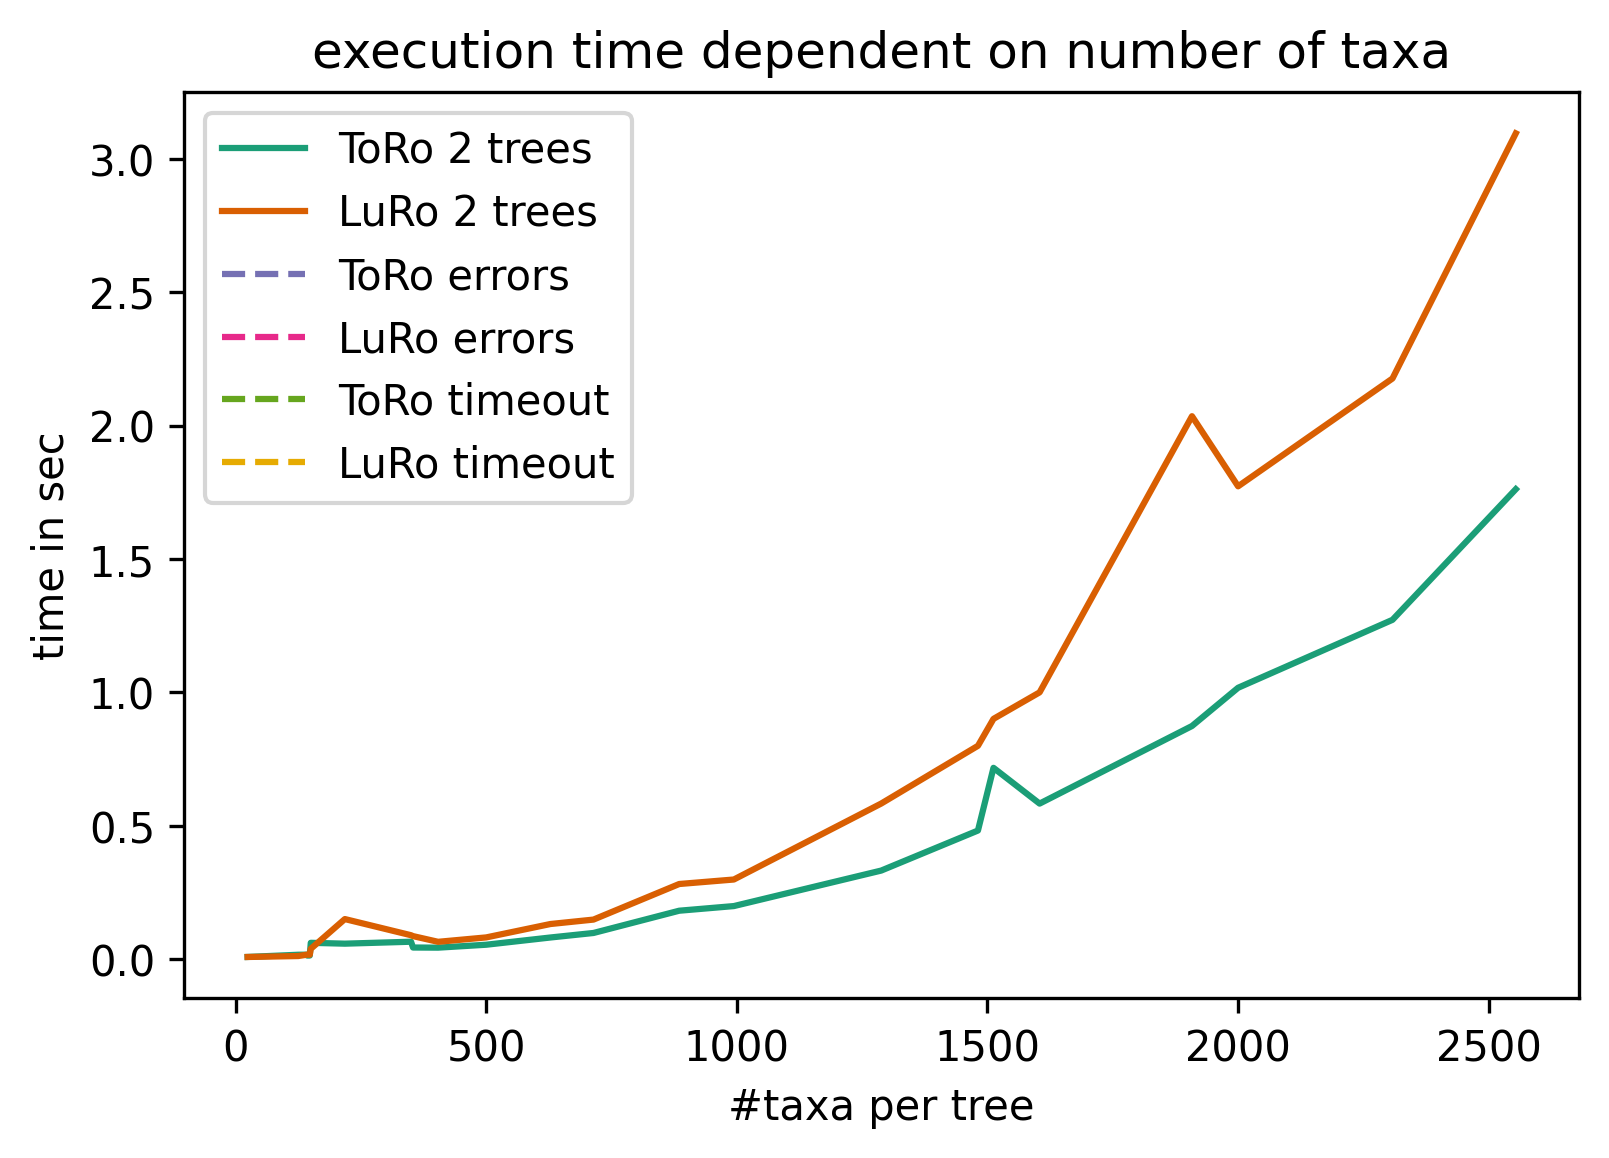

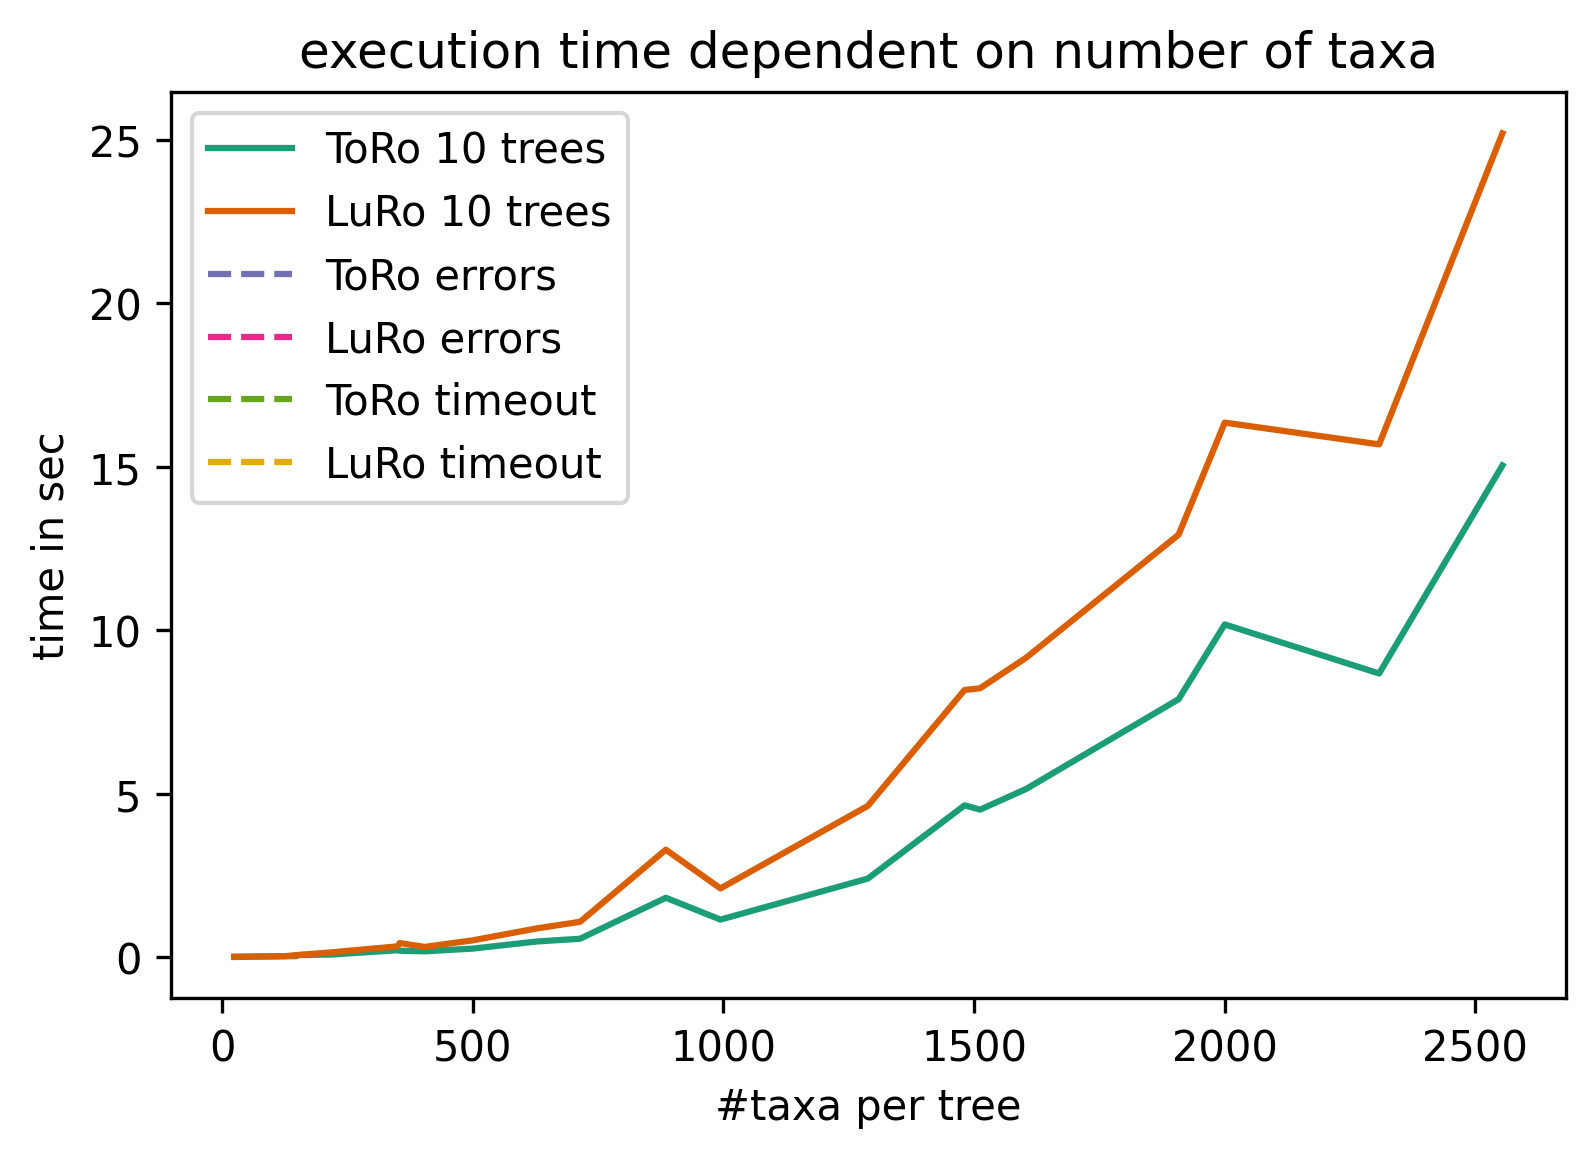

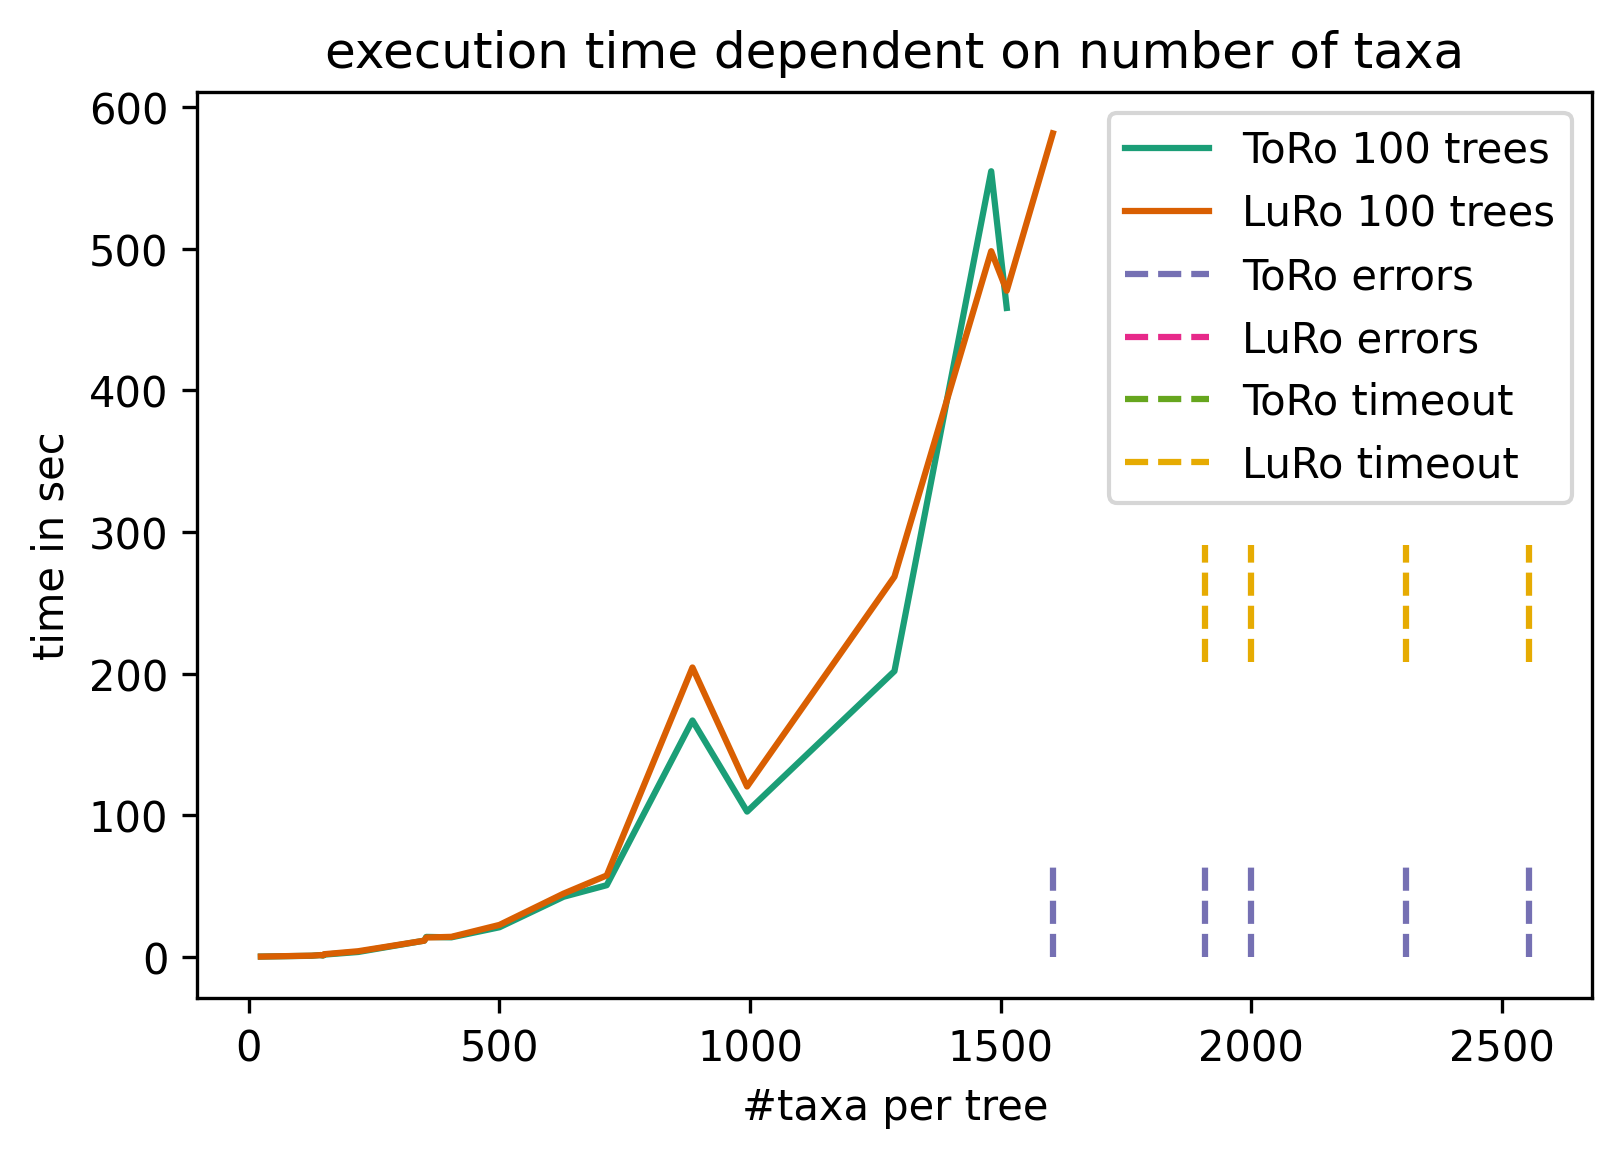

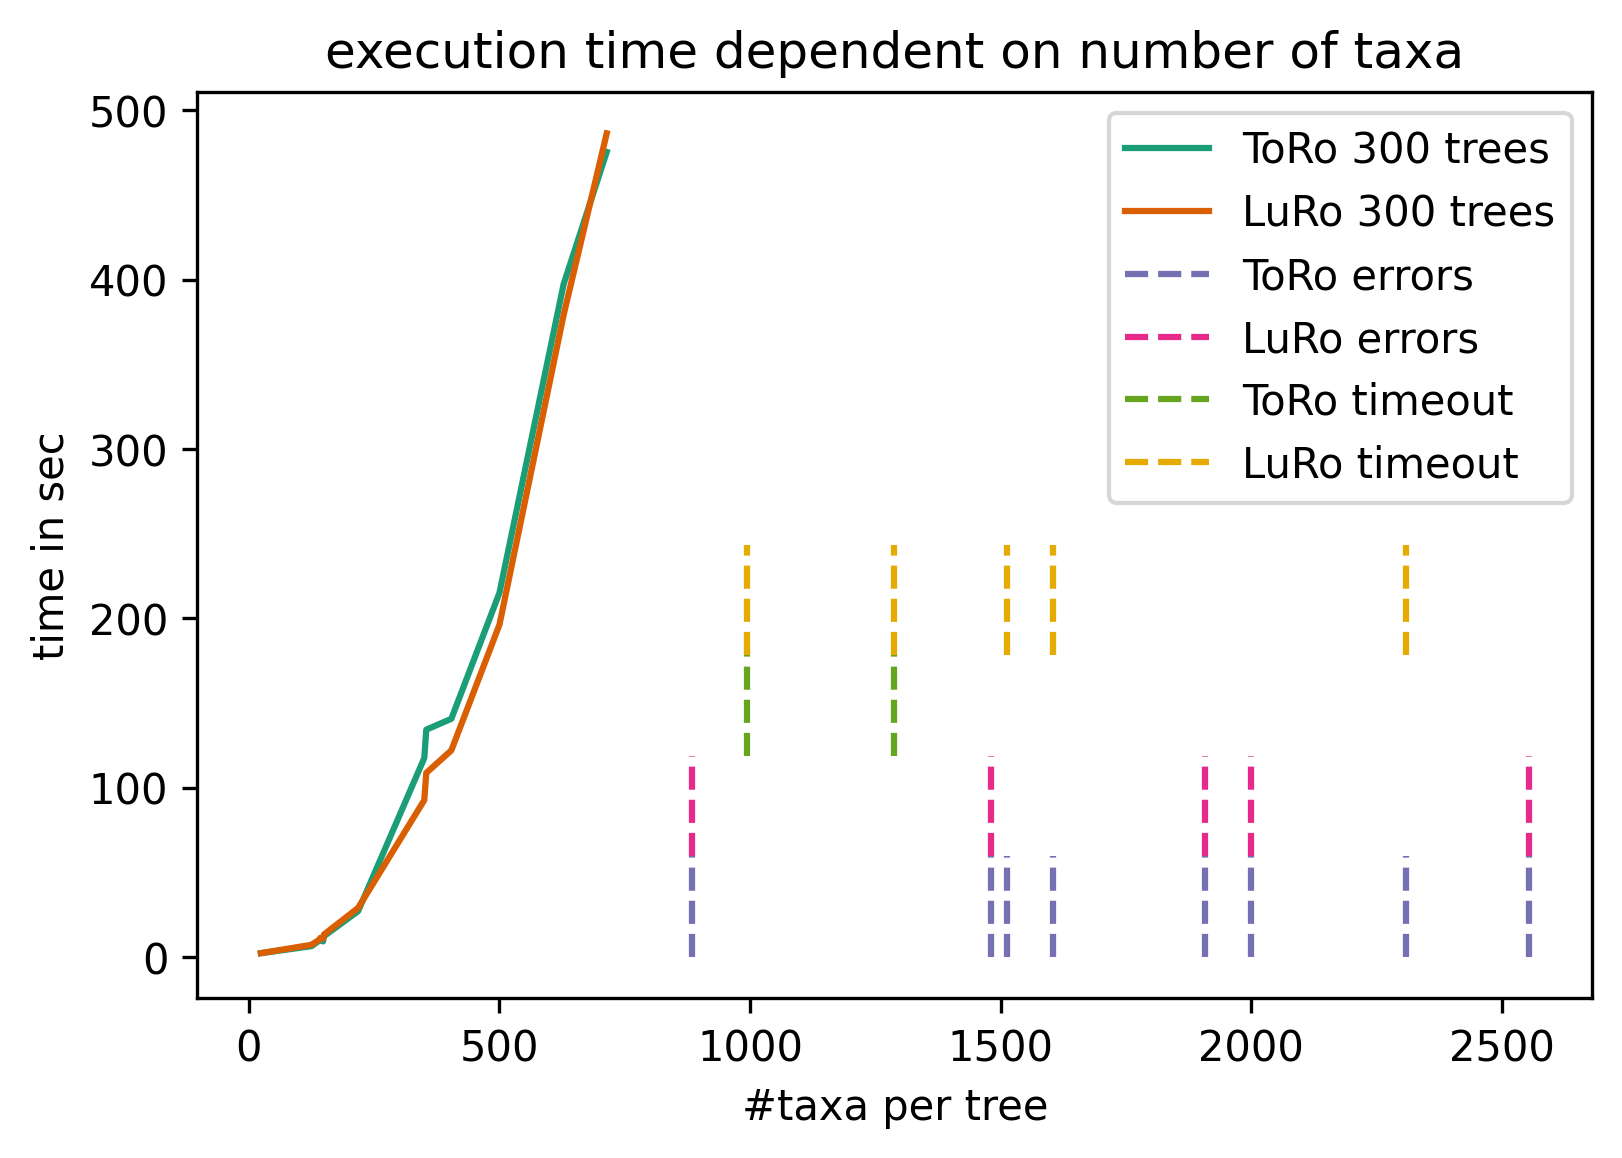

In [5]:
# plot contribution of taxa count

#need to get rid of invalid executions; np.all filters all metrics if one failed
for i, trees in enumerate(tree_values):
    # filter metrics where at least one is invalid
    invMO = np.all(getInvalidMask(ours[i,:,:]),axis=1)
    invMR = np.all(getInvalidMask(ref[i,:,:]),axis=1)
    noZerosOurs = np.average(ours[i,invMO,:],axis=1)
    noZerosRef = np.average(ref[i,invMR,:],axis=1)
    # plot calculations
    plt.plot(num_taxa[invMO], noZerosOurs, label = f"ToRo {trees} trees", color='#1b9e77')
    plt.plot(num_taxa[invMR], noZerosRef, label = f"LuRo {trees} trees",color='#d95f02')
    
    # plot errors
    memMaskO =  np.all(getErrMask(ours),axis=2)[i,:]
    memMaskR =  np.all(getErrMask(ref),axis=2)[i,:]

    plt.vlines(num_taxa[~memMaskO], 0,np.max(noZerosOurs)/8., label= f"ToRo errors", linestyle='dashed', color='#7570b3')
    plt.vlines(num_taxa[~memMaskR], np.max(noZerosOurs)/8.,np.max(noZerosOurs)/4., label= f"LuRo errors", linestyle='dashed', color='#e7298a' )
    
    tMaskO =  np.all(getTimeoutMask(ours),axis=2)[i,:]
    tMaskR =  np.all(getTimeoutMask(ref),axis=2)[i,:]
    plt.vlines(num_taxa[~tMaskO], np.max(noZerosOurs)/4.,np.max(noZerosOurs)/4. + np.max(noZerosOurs)/8., label= f"ToRo timeout", linestyle='dashed', color='#66a61e')
    plt.vlines(num_taxa[~tMaskR], np.max(noZerosOurs)/4. + np.max(noZerosOurs)/8.,np.max(noZerosRef)/2., label= f"LuRo timeout", linestyle='dashed', color='#e6ab02' )
    
    plt.title("execution time dependent on number of taxa")
    plt.ylabel("time in sec")
    plt.xlabel("#taxa per tree")
    plt.legend()
    plt.show()


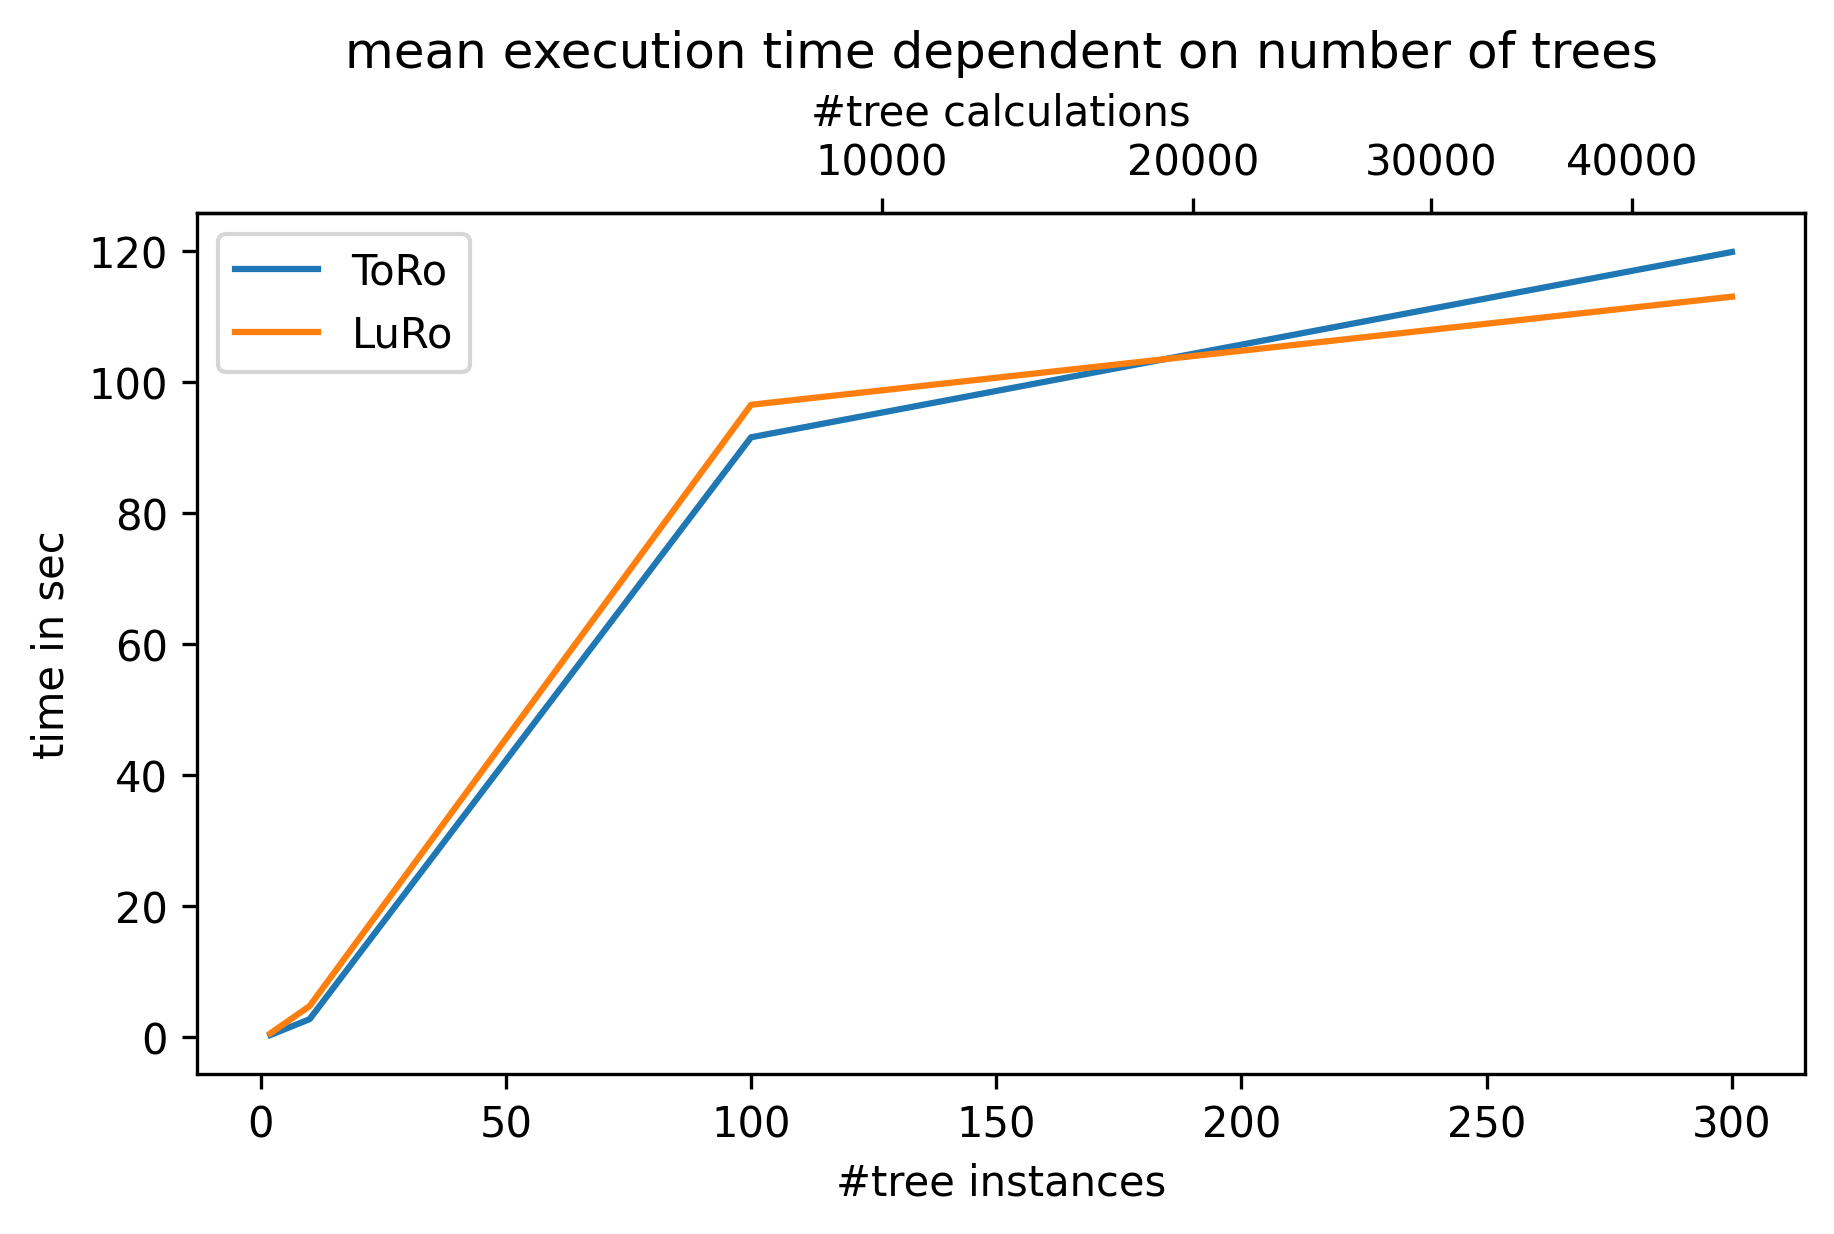

In [6]:
# plot contribution of tree count
tree_calcs = tree_values

invMO = np.all(getInvalidMask(ours),axis=2)
invMR = np.all(getInvalidMask(ref),axis=2)

tree_avgsO = []
tree_avgsR = []
for idx,tree in enumerate(tree_values):
    filteredO = ours[idx,:,:]
    tree_avgsO.append(np.average(filteredO[invMO[idx,:]]))
    filteredR = ref[idx,:,:]
    tree_avgsR.append(np.average(filteredR[invMO[idx,:]]))

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(tree_calcs,tree_avgsO, label="ToRo")
ax.plot(tree_calcs,tree_avgsR, label="LuRo")
ax.set_xlabel("#tree instances")
def trees2calc(trees):
    return trees * (trees+1)/2
def calc2trees(calc):
    return 0.5 * (np.sqrt(8*calc+1)-1)

secax = ax.secondary_xaxis('top', functions=(trees2calc, calc2trees))
secax.set_xlabel("#tree calculations")

plt.title("mean execution time dependent on number of trees")
plt.ylabel("time in sec")
plt.legend()
plt.show()
